In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Data Cleaning

In [28]:
df_zillow = pd.read_csv('zillow-california.csv')

In [29]:
df_zillow.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate,MedianRentalPrice_AllHomes.California
0,2004-01-31,326752.55,5.02,7.9,NaN
1,2004-02-29,329501.50,4.94,7.8,NaN
2,2004-03-31,340125.45,4.74,7.8,NaN
3,2004-04-30,355329.50,5.16,7.5,NaN
4,2004-05-31,367818.15,5.64,7.3,NaN


In [30]:
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 5 columns):
Date                                     164 non-null object
MedianSoldPrice_AllHomes.California      144 non-null float64
MedianMortageRate                        164 non-null float64
UnemploymentRate                         164 non-null float64
MedianRentalPrice_AllHomes.California    92 non-null float64
dtypes: float64(4), object(1)
memory usage: 6.5+ KB


In [58]:
#Change Date to datetime object, sort by Date, set Date as index
df_zillow['Date'] = pd.to_datetime(df_zillow.Date)
df_zillow = df_zillow.sort_values(by = "Date")
df_zillow = df_zillow.set_index('Date')

In [35]:
df_zillow = df_zillow.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianPrice","MedianRentalPrice_AllHomes.California" : "MedianRentalPrice"})

In [38]:
#Explore missing data
def percent_missing(df, column_name):
    perc_na = sum(df[column_name].isna()) / len(df[column_name])
    return perc_na

In [39]:
for column_name in df_zillow.columns:
    print(column_name, percent_missing(df_zillow, column_name))

Date 0.0
MedianPrice 0.12195121951219512
MedianMortageRate 0.0
UnemploymentRate 0.0
MedianRentalPrice 0.43902439024390244


In [47]:
#Both MedianPrice and MedianRentalPrice are numerical column, explore median and mean 
Rental_mean = df_zillow['MedianRentalPrice'].mean()
Rental_median = df_zillow['MedianRentalPrice'].median()
Price_mean = df_zillow['MedianPrice'].mean()
Price_median = df_zillow['MedianPrice'].median()
print("Rental_mean: "+str(Rental_mean)+"\n"
     +"Rental_median: "+str(Rental_median)+"\n"
     +"Price_mean: "+str(Price_mean)+"\n"
     +"Price_median: "+str(Price_median))

Rental_mean: 2128.8315217391305
Rental_median: 2100.0
Price_mean: 382373.55590277765
Price_median: 382467.5


In [52]:
#fill numerical nan value with median
def df_fillna_num_column(df, column_names):
    for column_name in column_names:
        median = float(df[column_name].median())
        print(f"Column Name: {column_name}, Median: {median}")
        df[column_name+"_missing_record"] = [1 if x==True else 0 for x in df[column_name].isna()]
        print(f"Percent Missing: {sum(df[column_name+'_missing_record']) / len(df[column_name+'_missing_record'])}")
        df[column_name] = df[column_name].fillna(median)
        df[column_name] = df[column_name].astype(float)

In [53]:
num_cols = ["MedianRentalPrice", "MedianPrice"]

In [54]:
df_fillna_num_column(df_zillow, num_cols)

Column Name: MedianRentalPrice, Median: 2100.0
Percent Missing: 0.43902439024390244
Column Name: MedianPrice, Median: 382467.5
Percent Missing: 0.12195121951219512


In [55]:
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 0 to 163
Data columns (total 7 columns):
Date                                164 non-null datetime64[ns]
MedianPrice                         164 non-null float64
MedianMortageRate                   164 non-null float64
UnemploymentRate                    164 non-null float64
MedianRentalPrice                   164 non-null float64
MedianRentalPrice_missing_record    164 non-null int64
MedianPrice_missing_record          164 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 10.2 KB


In [59]:
df_zillow.head()

,MedianPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice,MedianRentalPrice_missing_record,MedianPrice_missing_record
Date,,,,,,
2004-01-31,326752.55,5.02,7.9,2100.0,1,0
2004-02-29,329501.50,4.94,7.8,2100.0,1,0
2004-03-31,340125.45,4.74,7.8,2100.0,1,0
2004-04-30,355329.50,5.16,7.5,2100.0,1,0
2004-05-31,367818.15,5.64,7.3,2100.0,1,0


## Business Question: Can we correctly predict MedianPrice of all california housing 

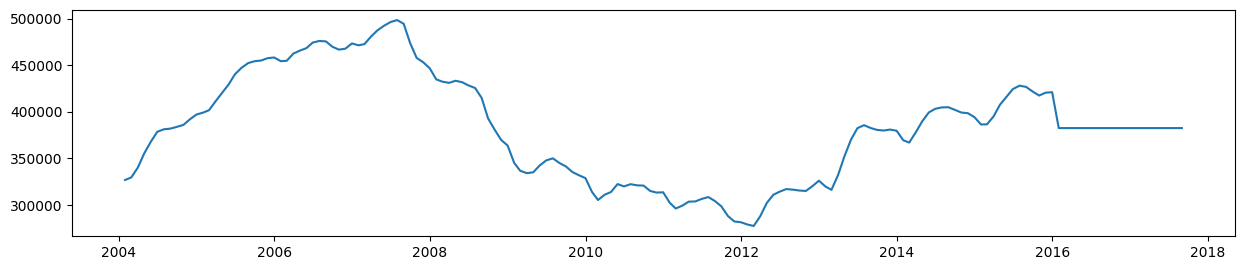

In [66]:
MedianPrice=df_zillow.MedianPrice
plt.figure(figsize=(15,3), dpi=100)
pyplot.plot(MedianPrice)
pyplot.show()

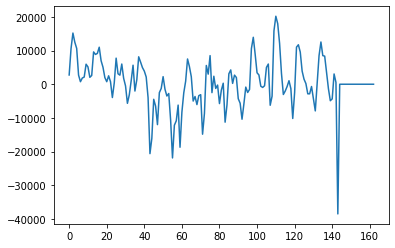

In [68]:
d1 = list()
for i in range(1, len(MedianPrice)):
    value = MedianPrice[i] - MedianPrice[i - 1]
    d1.append(value)

plt.plot(d1) 
pyplot.show()

In [70]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
adf_test(d1)

Results of Dickey-Fuller Test:
Test Statistic                  -2.079582
p-value                          0.252804
#Lags Used                      13.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64


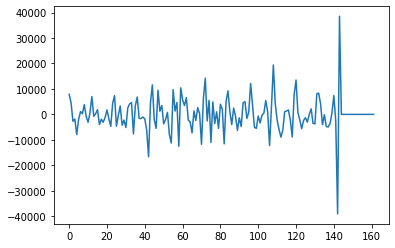

Results of Dickey-Fuller Test:
Test Statistic                  -5.136172
p-value                          0.000012
#Lags Used                      12.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64


In [71]:
d2 = list()
for i in range(1, len(d1)):
    value = d1[i] - d1[i - 1]
    d2.append(value)


plt.plot(d2) 
plt.show()

adf_test(d2)


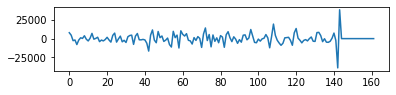

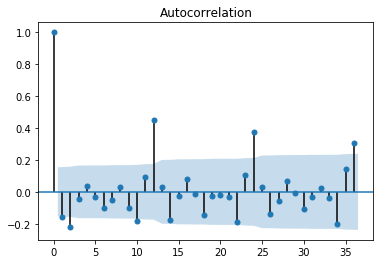

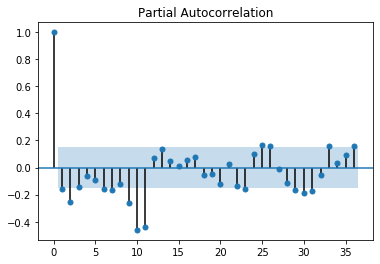

In [74]:
plt.subplot(3,1,1)
plt.plot(d2) 
plt.show()
plot_acf(d2,lags=36) 
plt.show()
plot_pacf(d2,lags=36) 
plt.show()

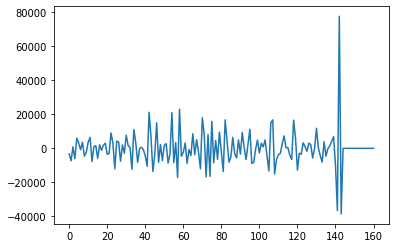

Results of Dickey-Fuller Test:
Test Statistic                -8.035966e+00
p-value                        1.902429e-12
#Lags Used                     1.400000e+01
Number of Observations Used    1.460000e+02
Critical Value (1%)           -3.475953e+00
Critical Value (5%)           -2.881548e+00
Critical Value (10%)          -2.577439e+00
dtype: float64


In [72]:
d3 = list()
for i in range(1, len(d2)):
    value = d2[i] - d2[i - 1]
    d3.append(value)


plt.plot(d3) 
plt.show()

adf_test(d3)

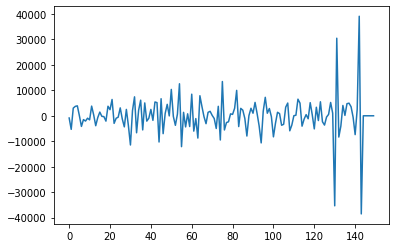

Results of Dickey-Fuller Test:
Test Statistic                -5.947962e+00
p-value                        2.181316e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.360000e+02
Critical Value (1%)           -3.479372e+00
Critical Value (5%)           -2.883037e+00
Critical Value (10%)          -2.578234e+00
dtype: float64


In [79]:
d4 = list()
for i in range(12, len(d2)):
    value = d2[i] - d2[i - 12]
    d4.append(value)


plt.plot(d4) 
plt.show()

adf_test(d4)

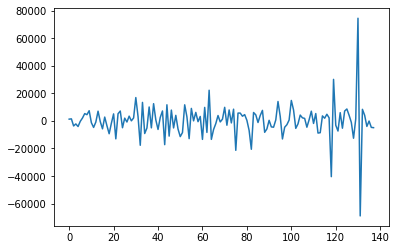

Results of Dickey-Fuller Test:
Test Statistic                -6.239504e+00
p-value                        4.735108e-08
#Lags Used                     1.300000e+01
Number of Observations Used    1.240000e+02
Critical Value (1%)           -3.484220e+00
Critical Value (5%)           -2.885145e+00
Critical Value (10%)          -2.579359e+00
dtype: float64


In [80]:
d5 = list()
for i in range(12, len(d4)):
    value = d4[i] - d4[i - 12]
    d5.append(value)


plt.plot(d5) 
plt.show()

adf_test(d5)

In [75]:
#Fit ARIMA model with d = 2 with seasonality m = 12 
#Do train-test split on 80-20 rules
train_size = int(len(MedianPrice) * 0.80)
train, test = MedianPrice[:train_size], MedianPrice[train_size:]
train.head()

Date
2004-01-31    326752.55
2004-02-29    329501.50
2004-03-31    340125.45
2004-04-30    355329.50
2004-05-31    367818.15
Name: MedianPrice, dtype: float64

In [87]:
import pmdarima as pm
model = pm.auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=2, D=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=2096.651, BIC=2109.921, Fit time=0.847 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 0, 12); AIC=2188.481, BIC=2193.789, Fit time=0.080 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 2, 0, 12); AIC=2190.861, BIC=2201.477, Fit time=0.198 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=2099.981, BIC=2110.597, Fit time=0.995 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 2, 1, 12); AIC=2125.667, BIC=2141.591, Fit time=1.047 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 0, 12); AIC=2170.917, BIC=2181.533, Fit time=0.338 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 2, 12); AIC=2127.797, BIC=2143.721, Fit time=2.256 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 2, 2, 12); AIC=2134.744, BIC=2153.322, Fit time=2.776 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=2125.385, BIC=2141.308, Fit time=0.989 seconds
Fit ARIMA: order=(1, 2, 0) s

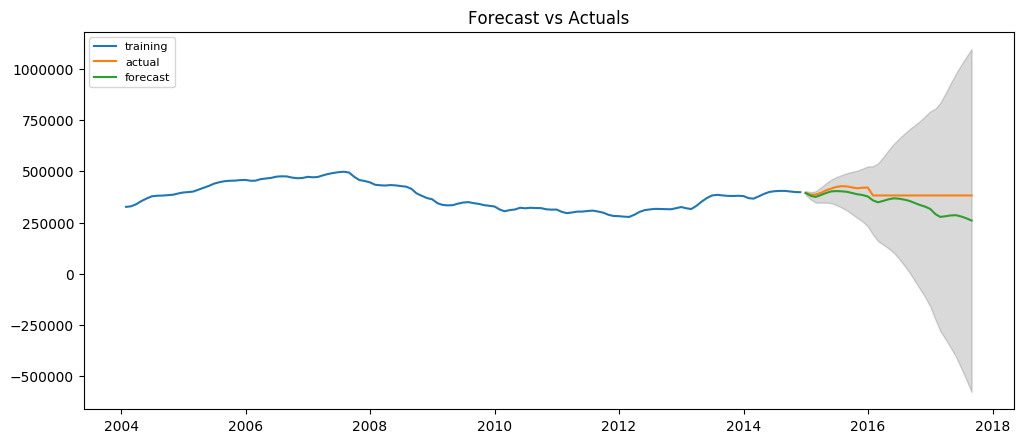

In [88]:
fitted = model.fit(train)
fc, conf = fitted.predict(len(test),return_conf_int=True,alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

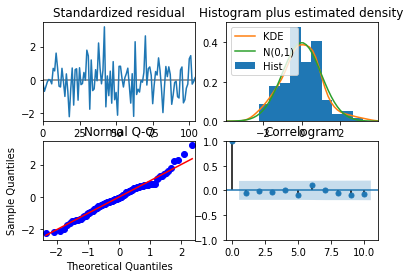

In [89]:
model.plot_diagnostics()
plt.show()

In [90]:
mse = ((fc_series - test) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

57310.97


In [91]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [92]:
model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12,damped=True)
model2 = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(len(test))
fit2 = model2.fit()
pred2 = fit2.forecast(len(test))

/Users/vivianchu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/vivianchu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/vivianchu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/vivianchu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


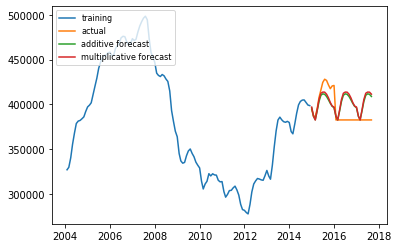

In [93]:
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='additive forecast')
plt.plot(pred2, label='multiplicative forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [94]:
rmse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
rmse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))
print(rmse1)
print(rmse2)

18371.967209018087
19250.202254084055


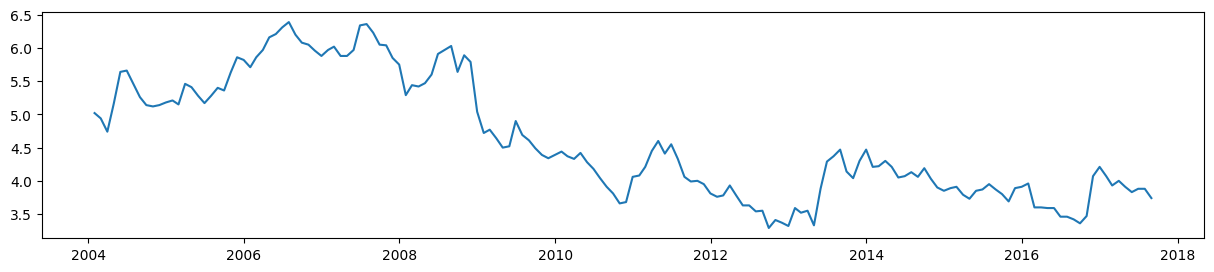

In [95]:
#SARIMAX on Mortgaeg Rate 
MortgageRate=df_zillow.MedianMortageRate
plt.figure(figsize=(15,3), dpi=100)
pyplot.plot(MortgageRate)
pyplot.show()

In [96]:
exog_train=MortgageRate[:train_size, None]
exog_test=MortgageRate[train_size:,None]

In [98]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [101]:
modelx = SARIMAX(train, order=(1,1,1),exog=exog_train)
fitx=modelx.fit()
print(fitx.summary())

                           Statespace Model Results                           
Dep. Variable:            MedianPrice   No. Observations:                  131
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1323.732
Date:                Fri, 06 Dec 2019   AIC                           2655.464
Time:                        12:07:54   BIC                           2666.934
Sample:                    01-31-2004   HQIC                          2660.125
                         - 11-30-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.232e+04   2733.701      4.506      0.000    6960.431    1.77e+04
ar.L1          0.9151      0.058     15.874      0.000       0.802       1.028
ma.L1         -0.8762      0.067    -13.137      0.0

/Users/vivianchu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
